#**스마트폰 센서 데이터 기반 모션 분류**
# 단계3 : 단계별 모델링


## 0.미션4

* 단계별로 나눠서 모델링을 수행하고자 합니다.  
* 단계 구분 예시
    * 단계1 : 정적(0), 동적(1) 행동 분류 모델 생성
    * 단계2 : 세부 동작에 대한 분류모델 생성
        * 단계1 모델에서 0으로 예측 -> 정적 행동 3가지 분류 모델링
        * 단계1 모델에서 1으로 예측 -> 동적 행동 3가지 분류 모델링
* 모델 통합
    * 두 단계 모델을 통합하고, 새로운 데이터에 대해서 최종 예측결과와 성능평가가 나오도록 함수로 만들기
* 성능 비교
    * 기본 모델링의 성능과 비교
    * 성능 가이드
        * Accuracy : 0.97 ~ 0.99
* 파이프라인 구성
    * test 데이터를 입력하여, 전처리 및 예측결과가 나오도록 함수 구성

## 1.환경설정

* 세부 요구사항
    - 경로 설정 : 구글콜랩
        * 구글 드라이브 바로 밑에 project3 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### (1) 경로 설정

* 구글 드라이브 연결

In [1361]:
# from google.colab import drive
# drive.mount('/content/drive')

In [1362]:
# path = '/content/drive/MyDrive/project3/'

### (2) 라이브러리 불러오기

* 라이브러리 로딩

In [1365]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import *

from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.backend import clear_session
from keras.optimizers import Adam

In [1366]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

### (3) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
    * data01_test.csv : 테스트용
    * feature.csv : feature 이름을 계층구조로 정리한 데이터

* 세부 요구사항
    * 칼럼 삭제 : data01_train.csv와 data01_test.csv 에서 'subject' 칼럼은 불필요하므로 삭제합니다.

#### 1) 데이터로딩

In [1370]:
path = ''

In [1371]:
data = pd.read_csv(path+'data01_train.csv')

In [1372]:
data = data.drop(columns=['subject'])

In [1373]:
data

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.535287,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.004012,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.157832,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5876,0.277194,-0.012389,-0.131974,-0.994046,-0.940578,-0.917337,-0.994261,-0.932830,-0.908088,-0.936219,...,-0.305772,-0.690363,-0.034888,-0.261437,-0.391477,-0.877612,-0.912365,0.114009,0.080146,SITTING
5877,0.191568,0.013328,-0.105174,-0.126969,-0.121729,-0.327480,-0.192523,-0.109923,-0.295286,0.078644,...,-0.622617,-0.879215,0.721718,0.623151,0.866858,-0.445660,-0.690278,0.303194,-0.044188,WALKING_UPSTAIRS
5878,0.267981,-0.018348,-0.107440,-0.991303,-0.989881,-0.990313,-0.992386,-0.988852,-0.991237,-0.936099,...,-0.597610,-0.886851,0.060173,0.228739,0.684400,-0.216665,0.620363,-0.437247,-0.571840,LAYING
5879,0.212787,-0.048130,-0.121001,-0.041373,0.052449,-0.585361,-0.100714,0.023353,-0.554707,0.219814,...,0.196921,-0.053556,0.260880,0.551742,-0.943773,-0.862899,-0.718009,0.292856,0.024920,WALKING_UPSTAIRS


#### 2) 기본 정보 조회

In [1375]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5881 entries, 0 to 5880
Columns: 562 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), object(1)
memory usage: 25.2+ MB


In [1376]:
data.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
count,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,...,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000
mean,0.274811,-0.017799,-0.109396,-0.603138,-0.509815,-0.604058,-0.628151,-0.525944,-0.605374,-0.465490,...,0.126955,-0.305883,-0.623548,0.008524,-0.001185,0.009340,-0.007099,-0.491501,0.059299,-0.054594
std,0.067614,0.039422,0.058373,0.448807,0.501815,0.417319,0.424345,0.485115,0.413043,0.544995,...,0.249176,0.322808,0.310371,0.339730,0.447197,0.608190,0.476738,0.509069,0.297340,0.278479
min,-0.503823,-0.684893,-1.000000,-1.000000,-0.999844,-0.999667,-1.000000,-0.999419,-1.000000,-1.000000,...,-0.965725,-0.979261,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.980143
25%,0.262919,-0.024877,-0.121051,-0.992774,-0.977680,-0.980127,-0.993602,-0.977865,-0.980112,-0.936067,...,-0.021610,-0.541969,-0.845985,-0.122361,-0.294369,-0.481718,-0.373345,-0.811397,-0.018203,-0.141555
50%,0.277154,-0.017221,-0.108781,-0.943933,-0.844575,-0.856352,-0.948501,-0.849266,-0.849896,-0.878729,...,0.133887,-0.342923,-0.712677,0.010278,0.005146,0.011448,-0.000847,-0.709441,0.182893,0.003951
75%,0.288526,-0.010920,-0.098163,-0.242130,-0.034499,-0.262690,-0.291138,-0.068857,-0.268539,-0.013690,...,0.288944,-0.127371,-0.501158,0.154985,0.285030,0.499857,0.356236,-0.511330,0.248435,0.111932
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.946700,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,0.977344,0.478157,1.000000


In [1377]:
data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.535287,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.004012,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.157832,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS


In [1378]:
data.shape

C:\Users\User\anaconda3\Lib\site-packages\IPython\core\displayhook.py:281: UserWarning: Output cache limit (currently 1000 entries) hit.
Flushing oldest 200 entries.
  warn('Output cache limit (currently {sz} entries) hit.\n'


(5881, 562)

## 2.데이터 전처리

* 세부 요구사항
    - Label 추가 : 1단계 모델을 위한 레이블 추가
    - train : val = 8 : 2 혹은 7 : 3
    - random_state 옵션을 사용하여 다른 모델과 비교를 위해 성능이 재현되도록 합니다.

### (1) 1단계 모델링을 위한 레이블

In [1382]:
data1 = data.copy()
target = 'Activity'

### (2) x, y 분리

In [1384]:
x = data1.drop(columns=target)
y = data1.loc[:,target]
print(y.unique())

['STANDING' 'LAYING' 'WALKING' 'WALKING_DOWNSTAIRS' 'WALKING_UPSTAIRS'
 'SITTING']


### (3) 가변수화

In [1386]:
y = y.map({'LAYING': 0, 'SITTING': 0, 'STANDING': 0, 
            'WALKING': 1, 'WALKING_UPSTAIRS': 1, 'WALKING_DOWNSTAIRS': 1})
y

0       0
1       0
2       0
3       1
4       1
       ..
5876    0
5877    1
5878    0
5879    1
5880    0
Name: Activity, Length: 5881, dtype: int64

### (4) 데이터 분할
* train, val 분할

In [1388]:
from sklearn.model_selection import train_test_split

x_train,x_val,y_train,y_val = train_test_split(x,y,stratify=y,random_state=1)

### (5) 스케일링(생략 이미 -1 ~ 1이라)


* 세부 요구사항
    - 스케일링을 필요로 하는 알고리즘 사용을 위해서 코드 수행
    - min-max 방식 혹은 standard 방식 중 한가지 사용.

## **3.단계별 모델링**

### (1) 단계1

* 세부 요구사항
    * 적절한 단계로 구분한 후, 1단계를 분류하는 모델 생성
        * 예시 : 정적 행동(Laying, Sitting, Standing)과 동적 행동(동적 : Walking, Walking-Up, Walking-Down)을 구분하는 모델 생성.
    * 몇 가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

#### 1) 모델1

In [1395]:
nfeatures = x.shape[1]
nfeatures

561

In [1396]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import *

from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Input
from keras.backend import clear_session
from keras.optimizers import Adam
clear_session()

model = Sequential([Input(shape=(nfeatures,)),
                   Dense(128,activation='relu'),
                   Dense(64,activation='relu'),
                   Dense(1,activation='sigmoid')])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │          71,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 80,257 (313.50 KB)

 Trainable params: 80,257 (313.50 KB)

 Non-trainable params: 0 (0.00 B)

In [1397]:
model.compile(optimizer=Adam(learning_rate=0.001),loss = 'binary_crossentropy')
hist = model.fit(x,y,epochs=50,validation_split=.2).history

Epoch 1/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0821 - val_loss: 0.0021
Epoch 2/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 8.0031e-04 - val_loss: 0.0079
Epoch 3/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.3762e-04 - val_loss: 0.0015
Epoch 4/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.3148e-05 - val_loss: 0.0021
Epoch 5/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.2623e-05 - val_loss: 0.0024
Epoch 6/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.7655e-05 - val_loss: 0.0028
Epoch 7/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.3499e-05 - val_loss: 0.0020
Epoch 8/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.0463e-05 - val_loss: 0.0025
Epoch 9/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.3553e-05 - val_loss: 0.0034
Epoch 10/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 9.9675e-06 - val_loss: 0.0025
Epoch 11/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 9.8422e-06 - val_loss: 0.0031
Epoch 12/50


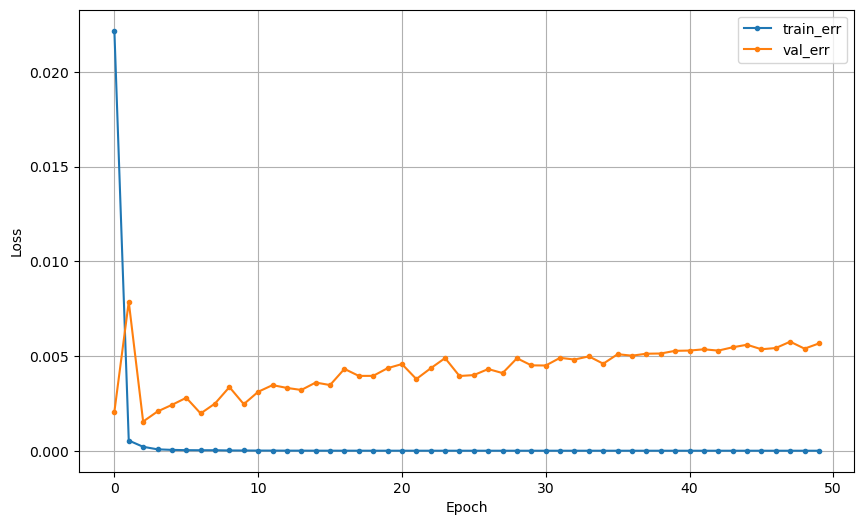

In [1398]:
dl_history_plot(hist)

In [1399]:
from sklearn.metrics import classification_report, accuracy_score

# 예측 수행
y_pred = model.predict(x_val)

# 예측 결과를 정수 레이블로 변환
y_pred = np.where(y_pred >= .5, 1, 0)

print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))
print(accuracy_score(y_val,y_pred))

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
[[809   0]
 [  0 662]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       809
           1       1.00      1.00      1.00       662

    accuracy                           1.00      1471
   macro avg       1.00      1.00      1.00      1471
weighted avg       1.00      1.00      1.00      1471

1.0


#### 2) 모델2

### (2) 단계2

#### 1) 단계2-1 : 정적 동작 세부 분류

* 세부 요구사항
    * 정적 행동(Laying, Sitting, Standing)인 데이터 추출
    * Laying, Sitting, Standing 를 분류하는 모델을 생성
    * 몇가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

In [1404]:
# 타겟 열 정의
target = 'Activity'

# 정적 데이터 추출
static_data = data[data[target].isin(['SITTING', 'LAYING', 'STANDING'])]
static_data

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.535287,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING
7,0.272026,-0.001329,-0.125491,-0.992068,-0.912985,-0.972451,-0.994752,-0.943141,-0.976428,-0.925446,...,-0.258503,-0.704995,-0.024442,0.076332,0.741277,0.729812,-0.817201,0.037746,0.136129,STANDING
8,0.284338,0.021956,-0.006925,-0.980153,-0.838394,-0.782357,-0.983683,-0.816199,-0.743923,-0.914011,...,-0.052863,-0.400197,0.021212,-0.009465,-0.282762,0.563343,-0.782072,0.242834,-0.025285,STANDING
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5874,0.257476,-0.413865,0.017374,-0.919666,0.075259,-0.630716,-0.937986,0.176796,-0.613510,-0.866296,...,0.285085,-0.091605,-0.000793,0.267189,-0.186202,0.098099,0.792970,-0.034020,-0.928148,LAYING
5875,0.277378,-0.013298,-0.104322,-0.996596,-0.987491,-0.973345,-0.996372,-0.987746,-0.973512,-0.942156,...,-0.750064,-0.956239,0.122320,0.136275,-0.708377,-0.507788,-0.818263,0.222620,0.035430,STANDING
5876,0.277194,-0.012389,-0.131974,-0.994046,-0.940578,-0.917337,-0.994261,-0.932830,-0.908088,-0.936219,...,-0.305772,-0.690363,-0.034888,-0.261437,-0.391477,-0.877612,-0.912365,0.114009,0.080146,SITTING
5878,0.267981,-0.018348,-0.107440,-0.991303,-0.989881,-0.990313,-0.992386,-0.988852,-0.991237,-0.936099,...,-0.597610,-0.886851,0.060173,0.228739,0.684400,-0.216665,0.620363,-0.437247,-0.571840,LAYING


In [1405]:
static_x = static_data.drop(columns=target)
static_y = static_data[target]
static_y


0       STANDING
1         LAYING
2       STANDING
7       STANDING
8       STANDING
          ...   
5874      LAYING
5875    STANDING
5876     SITTING
5878      LAYING
5880     SITTING
Name: Activity, Length: 3234, dtype: object

In [1406]:
static_y = static_y.map({'SITTING' : 1,'LAYING' : 0,'STANDING' : 2})
static_y

0       2
1       0
2       2
7       2
8       2
       ..
5874    0
5875    2
5876    1
5878    0
5880    1
Name: Activity, Length: 3234, dtype: int64

In [1407]:
from keras.utils import to_categorical

# 원-핫 인코딩
static_y = to_categorical(static_y, num_classes=3)  # num_classes는 클래스 수

In [1408]:
x_train,x_val,y_train,y_val = train_test_split(static_x,static_y,stratify=static_y,random_state=1)

In [1409]:
nfeatures = static_x.shape[1]
nfeatures

561

In [1410]:
clear_session()

model2 = Sequential([Input(shape=(nfeatures,)),
                   Dense(256,activation='relu'),
                   Dense(128,activation='relu'),
                   Dense(64,activation='relu'),
                   Dense(32,activation='relu'),
                   Dense(16,activation='relu'),
                   Dense(3,activation='softmax')])
model2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         143,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 187,683 (733.14 KB)

 Trainable params: 187,683 (733.14 KB)

 Non-trainable params: 0 (0.00 B)

In [1411]:
model2.compile(optimizer=Adam(learning_rate=0.001),loss = 'categorical_crossentropy')
hist = model2.fit(static_x,static_y,epochs=50,validation_split=.2).history

Epoch 1/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.9653 - val_loss: 0.3429
Epoch 2/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.3301 - val_loss: 0.1795
Epoch 3/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1917 - val_loss: 0.2394
Epoch 4/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1915 - val_loss: 0.1058
Epoch 5/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1349 - val_loss: 0.1541
Epoch 6/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1354 - val_loss: 0.0950
Epoch 7/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1351 - val_loss: 0.1044
Epoch 8/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1544 - val_loss: 0.0894
Epoch 9/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0922 - val_loss: 0.1112
Epoch 10/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1217 - val_loss: 0.1254
Epoch 11/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1031 - val_loss: 0.0870
Epoch 12/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1509 - va

In [1412]:
y_pred = model2.predict(x_val)
y_pred = y_pred.argmax(axis=1)
y_pred
y_val = y_val.argmax(axis=1)
y_val

print(classification_report(y_val,y_pred))

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       279
           1       0.93      1.00      0.96       258
           2       1.00      0.93      0.97       272

    accuracy                           0.98       809
   macro avg       0.98      0.98      0.98       809
weighted avg       0.98      0.98      0.98       809



#### 2) 단계2-2 : 동적 동작 세부 분류

* 세부 요구사항
    * 동동적 행동(Walking, Walking Upstairs, Walking Downstairs)인 데이터 추출
    * Walking, Walking Upstairs, Walking Downstairs 를 분류하는 모델을 생성
    * 몇가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

In [1415]:
# 타겟 열 정의
target = 'Activity'

# 정적 데이터 추출
dynamic_data = data[data[target].isin(['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS'])]
dynamic_data

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.004012,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.157832,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS
5,0.330708,0.007561,-0.061371,-0.215760,0.101075,0.072949,-0.269857,0.060060,0.101298,-0.019263,...,-0.599906,-0.887024,-0.030645,-0.852091,-0.500195,0.306091,-0.552729,0.253885,0.291256,WALKING_UPSTAIRS
6,0.121465,-0.031902,-0.005196,-0.152198,-0.113104,-0.239423,-0.202401,-0.164698,-0.247099,0.114668,...,-0.371055,-0.775779,0.445206,-0.003487,-0.940185,0.041387,-0.886603,0.173338,-0.005627,WALKING
12,0.303885,0.002768,-0.038613,-0.168656,0.190336,-0.140473,-0.205134,0.101144,-0.120572,-0.000818,...,-0.037750,-0.329728,-0.040030,0.257252,0.076091,-0.123425,-0.752882,0.266729,0.045692,WALKING
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5868,0.277709,-0.053919,-0.098746,-0.589970,-0.076626,-0.500837,-0.605474,-0.142798,-0.506696,-0.533485,...,0.029201,-0.268237,-0.076922,0.706620,-0.954969,-0.324779,-0.691663,0.153974,-0.196833,WALKING
5869,0.252496,-0.009773,-0.118293,-0.155168,-0.244513,-0.044524,-0.244367,-0.229509,-0.042199,0.291682,...,-0.475800,-0.752980,0.619246,-0.684483,0.924623,-0.353041,-0.775518,0.253218,0.013216,WALKING_UPSTAIRS
5873,0.264961,-0.034719,-0.088140,-0.368158,-0.074514,-0.229606,-0.394387,-0.082437,-0.243525,-0.261087,...,0.198624,-0.046157,0.037517,-0.903692,0.614933,-0.610918,-0.601604,0.335996,0.156518,WALKING
5877,0.191568,0.013328,-0.105174,-0.126969,-0.121729,-0.327480,-0.192523,-0.109923,-0.295286,0.078644,...,-0.622617,-0.879215,0.721718,0.623151,0.866858,-0.445660,-0.690278,0.303194,-0.044188,WALKING_UPSTAIRS


In [1416]:
dynamic_x = dynamic_data.drop(columns=target)
dynamic_y = dynamic_data[target]
dynamic_y

3                  WALKING
4       WALKING_DOWNSTAIRS
5         WALKING_UPSTAIRS
6                  WALKING
12                 WALKING
               ...        
5868               WALKING
5869      WALKING_UPSTAIRS
5873               WALKING
5877      WALKING_UPSTAIRS
5879      WALKING_UPSTAIRS
Name: Activity, Length: 2647, dtype: object

In [1417]:
dynamic_y = dynamic_y.map({'WALKING' : 0,'WALKING_UPSTAIRS' : 1,'WALKING_DOWNSTAIRS' : 2})
dynamic_y

3       0
4       2
5       1
6       0
12      0
       ..
5868    0
5869    1
5873    0
5877    1
5879    1
Name: Activity, Length: 2647, dtype: int64

In [1418]:
dynamic_y = to_categorical(dynamic_y, num_classes=3)  # num_classes는 클래스 수

In [1419]:
x_train,x_val,y_train,y_val = train_test_split(dynamic_x,dynamic_y,stratify=dynamic_y,random_state=1)

In [1420]:
nfeatures = dynamic_x.shape[1]
nfeatures

561

In [1421]:
clear_session()

model3 = Sequential([Input(shape=(nfeatures,)),
                   Dense(256,activation='relu'),
                   Dense(128,activation='relu'),
                   Dense(64,activation='relu'),
                   Dense(32,activation='relu'),
                   Dense(16,activation='relu'),
                   Dense(3,activation='softmax')])
model3.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         143,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 187,683 (733.14 KB)

 Trainable params: 187,683 (733.14 KB)

 Non-trainable params: 0 (0.00 B)

In [1422]:
model3.compile(optimizer=Adam(learning_rate=0.001),loss = 'categorical_crossentropy')
hist = model3.fit(dynamic_x,dynamic_y,epochs=50,validation_split=.2).history

Epoch 1/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.8028 - val_loss: 0.1773
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1380 - val_loss: 0.0532
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0752 - val_loss: 0.0778
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0301 - val_loss: 0.0597
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0776 - val_loss: 0.0253
Epoch 6/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0109 - val_loss: 0.0177
Epoch 7/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0163 - val_loss: 0.0597
Epoch 8/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0410 - val_loss: 0.0198
Epoch 9/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0110 - val_loss: 0.0085
Epoch 10/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0028 - val_loss: 0.0092
Epoch 11/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.9879e-04 - val_loss: 0.0100
Epoch 12/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.0565e-04

In [1423]:
y_pred = model3.predict(x_val)
y_pred = y_pred.argmax(axis=1)
y_val = y_val.argmax(axis=1)
print(y_pred)
print(y_val)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
[2 0 1 1 1 1 1 1 2 0 0 2 1 1 2 0 0 2 0 0 0 0 1 0 2 1 1 1 2 0 1 0 2 2 1 2 1
 1 1 1 0 1 0 0 0 0 2 0 1 1 1 1 0 0 2 0 1 1 2 2 2 1 1 1 0 0 0 0 1 1 2 0 2 0
 1 1 2 1 0 0 1 2 0 1 2 1 2 0 2 2 0 2 0 0 0 2 0 2 1 1 1 0 1 1 1 0 0 1 1 0 2
 2 2 0 2 0 0 1 1 0 1 1 2 0 2 0 0 1 1 2 2 1 0 2 1 1 1 0 0 2 1 0 1 1 2 2 1 2
 2 2 0 2 0 1 1 1 1 0 2 1 0 2 1 0 0 2 0 1 2 0 1 0 2 0 0 2 0 2 0 1 1 1 1 0 0
 0 0 0 0 0 0 2 0 0 2 2 0 0 1 2 2 0 2 0 2 0 1 2 2 0 2 2 1 0 2 1 1 2 1 1 2 1
 2 1 1 2 0 2 2 1 0 1 1 2 0 2 0 2 2 1 2 1 1 0 1 0 2 0 0 0 0 0 1 0 2 0 0 2 1
 0 1 1 0 2 0 1 1 1 2 0 2 1 2 0 1 0 2 1 1 1 0 0 1 1 2 1 0 1 2 1 2 1 1 0 2 0
 2 0 2 1 0 0 2 2 0 0 2 0 0 0 2 1 2 2 2 2 0 1 2 2 1 2 0 2 0 0 0 1 1 2 1 0 1
 0 2 0 2 2 0 1 1 0 2 2 0 2 0 0 0 0 2 2 2 2 0 0 2 0 1 1 1 2 2 1 2 2 0 0 2 0
 2 0 2 0 2 2 0 1 1 1 0 1 1 2 2 1 1 0 2 0 1 1 0 0 2 2 0 2 0 1 1 1 1 1 0 0 1
 0 1 1 1 1 1 2 0 0 0 1 1 1 0 1 1 1 2 2 0 0 0 1 1 0 2 0 2 0 0 0 0 2 0 0 2 0
 2 1 0 2 1 1 0 1 1 0 0 0 0 0 1 0 0 1 0 0 2 1 1 1 0 0 2 2 0 0

In [1424]:
print(confusion_matrix(y_val,y_pred))
print(classification_report(y_val,y_pred))

[[250   0   0]
 [  0 214   0]
 [  0   1 197]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       250
           1       1.00      1.00      1.00       214
           2       1.00      0.99      1.00       198

    accuracy                           1.00       662
   macro avg       1.00      1.00      1.00       662
weighted avg       1.00      1.00      1.00       662



### (3) 분류 모델 파이프라인 구성


* 세부 요구사항
    * 두 단계 모델을 통합하고, 새로운 데이터(test)에 대해서 최종 예측결과와 성능평가가 나오도록 함수로 만들기
    * 데이터 파이프라인 구축 : test데이터가 로딩되어 전처리 과정을 거치고, 예측 및 성능 평가 수행

* 예시
![](https://github.com/DA4BAM/image/blob/main/pipeline%20function.png?raw=true)

#### 1) 함수 만들기

In [1429]:
from sklearn.metrics import classification_report

def pipeLine(data, model1, model2, model3):
    data1 = data.copy()
    data1 = data1.drop(columns=['subject'])  # 'subject' 열 제거
    target = 'Activity'
    
    # 타겟 레이블을 숫자로 매핑
    y = data1[target]
    y_val = y.map({'LAYING': 0, 'SITTING': 1, 'STANDING': 2, 
                    'WALKING': 3, 'WALKING_UPSTAIRS': 4, 'WALKING_DOWNSTAIRS': 5})
    
    # 특성과 타겟 분리
    x = data1.drop(columns=target)
    
    # 모델 1을 사용하여 예측 수행
    y_pred = model1_pipeLine(x, model1)  # data1 사용
    
    result = []  # 빈 리스트로 초기화

    # y_pred의 길이와 x의 길이를 확인
    if len(y_pred) != len(x):
        print(len(y_pred))
        print(len(x))
        raise ValueError("y_pred의 길이와 x의 길이가 일치하지 않습니다.")
    
    # 예측 결과에 따라 다른 모델 호출
    for i in range(len(x)):  # x의 길이를 사용
        if y_pred[i] == 0:
            new_data = model2_pipeLine(x.iloc[[i]], model2)
        else:
            new_data = model3_pipeLine(x.iloc[[i]], model3)
        result.append(new_data)
    
    # result를 1차원 배열로 변환
    result = np.array(result).flatten()  # flatten()을 사용하여 1차원 배열로 변환
    
    # 결과 출력
    print("예측 결과:", result)
    print("실제 레이블:", y_val.tolist())
    
    # classification_report 출력
    print(confusion_matrix(y_val,result))
    print(classification_report(y_val, result))


In [1430]:
def model1_pipeLine(data,model) :
    y_pred = model.predict(data)
    y_pred = np.where(y_pred >= .5, 1, 0)
    return y_pred;

In [1431]:
def model2_pipeLine(data,model) :
    y_pred = model.predict(data)
    y_pred = y_pred.argmax(axis=1)
    print('모델2 실행')
    print(y_pred)
    return y_pred

In [1432]:
def model3_pipeLine(data,model) :
    y_pred = model.predict(data)
    y_pred = y_pred.argmax(axis=1) + 3
    print('모델3 실행')
    print(y_pred)
    return y_pred

#### 2) test 셋으로 예측하고 평가하기

In [1494]:
testdata = pd.read_csv('data01_test.csv')

In [1495]:
len(testdata)

1471

In [1496]:
# testdata = testdata.iloc[:100]

In [ ]:
pipeLine(testdata,model,model2,model3)

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
모델2 실행
[1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
모델2 실행
[2]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
모델3 실행
[3]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
모델2 실행
[1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
모델2 실행
[2]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
모델3 실행
[3]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
모델2 실행
[2]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
모델2 실행
[2]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
모델2 실행
[1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
모델3 실행
[4]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
모델2 실행
[2]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
모델2 실행
[2]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
모델2 실행
[0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
모델2 실행
[0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
모델2 실행
[1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
모델2 실행
[0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
모델3 실행
[4]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
모델3 실행
[3]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
모델3 실행
[5]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47